Датасет: https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, roc_auc_score, f1_score

In [ ]:
df = pd.read_csv('/content/heart_disease_uci.csv')
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [ ]:
df = df.drop(columns=['id'])

print(df.info())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       920 non-null    int64  
 1   sex       920 non-null    object 
 2   dataset   920 non-null    object 
 3   cp        920 non-null    object 
 4   trestbps  861 non-null    float64
 5   chol      890 non-null    float64
 6   fbs       830 non-null    object 
 7   restecg   918 non-null    object 
 8   thalch    865 non-null    float64
 9   exang     865 non-null    object 
 10  oldpeak   858 non-null    float64
 11  slope     611 non-null    object 
 12  ca        309 non-null    float64
 13  thal      434 non-null    object 
 14  num       920 non-null    int64  
dtypes: float64(5), int64(2), object(8)
memory usage: 107.9+ KB
None
age           0
sex           0
dataset       0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
old

In [ ]:
df['target'] = df['num'].apply(lambda x: 0 if x == 0 else 1)
df = df.drop(columns=['num'])

In [ ]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
print("Категориальные признаки:", cat_cols)
df.replace('?', np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')

for column in df.columns:
    if pd.api.types.is_numeric_dtype(df[column]):
        median_value = df[column].median()
        df[column] = df[column].fillna(median_value)

df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

Категориальные признаки: ['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


In [ ]:
X = df.drop(columns=['target']).values
y = df['target'].values

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=50, stratify=y)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("NaN in X_train:", np.isnan(X_train).sum())
print("Inf in X_train:", np.isinf(X_train).sum())
print("NaN in y_train:", np.isnan(y_train).sum())
print("Inf in y_train:", np.isinf(y_train).sum())

print("y_train unique values:", np.unique(y_train))

X_train shape: (736, 8)
y_train shape: (736,)
NaN in X_train: 0
Inf in X_train: 0
NaN in y_train: 0
Inf in y_train: 0
y_train unique values: [0 1]


In [ ]:
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 64

train_dataset = TabularDataset(X_train, y_train)
test_dataset = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

unique, counts = np.unique(y_train, return_counts=True)
print("Train class distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test class distribution:", dict(zip(unique, counts)))

Train class distribution: {np.int64(0): np.int64(329), np.int64(1): np.int64(407)}
Test class distribution: {np.int64(0): np.int64(82), np.int64(1): np.int64(102)}


In [ ]:
class_counts = np.bincount(y_train)
neg, pos = class_counts[0], class_counts[1]
pos_weight = torch.tensor([neg / pos], dtype=torch.float32)

print("Class distribution:", dict(zip([0,1], class_counts)))
print("pos_weight =", pos_weight.item())

Class distribution: {0: np.int64(329), 1: np.int64(407)}
pos_weight = 0.8083537817001343


In [ ]:
class HeartNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Dropout(0.25),

            nn.Linear(32, 16),
            nn.LeakyReLU(),
            nn.Dropout(0.2),

            nn.Linear(16, 1)
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
input_dim = X_train.shape[1]
model = HeartNet(input_dim)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)  # чуть больше L2

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

In [ ]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

In [ ]:
def train_model(model, train_loader, test_loader, optimizer, criterion, scheduler, epochs=30):
    early_stopping = EarlyStopping(patience=5)
    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(epochs):
        model.train()
        tloss, tcorrect, ttotal = 0.0, 0, 0
        for Xb, yb in train_loader:
            optimizer.zero_grad()
            logits = model(Xb).squeeze()
            loss = criterion(logits, yb)
            loss.backward()
            optimizer.step()

            tloss += loss.item()
            preds = (torch.sigmoid(logits) >= 0.5)
            tcorrect += (preds == yb).sum().item()
            ttotal += yb.size(0)

        model.eval()
        vloss, vcorrect, vtotal = 0.0, 0, 0
        with torch.no_grad():
            for Xb, yb in test_loader:
                logits = model(Xb).squeeze()
                loss = criterion(logits, yb)
                vloss += loss.item()
                preds = (torch.sigmoid(logits) >= 0.5)
                vcorrect += (preds == yb).sum().item()
                vtotal += yb.size(0)

        avg_tloss = tloss / len(train_loader)
        avg_vloss = vloss / len(test_loader)
        tacc = tcorrect / ttotal
        vacc = vcorrect / vtotal

        train_losses.append(avg_tloss)
        val_losses.append(avg_vloss)
        train_accs.append(tacc)
        val_accs.append(vacc)

        print(f"Epoch {epoch+1}/{epochs} — Train Loss: {avg_tloss:.4f}, Train Acc: {tacc:.4f} — Val Loss: {avg_vloss:.4f}, Val Acc: {vacc:.4f}")

        scheduler.step(avg_vloss)
        early_stopping(avg_vloss)
        if early_stopping.early_stop:
            print("Early stopping triggered!")
            break

    return train_losses, val_losses, train_accs, val_accs

In [ ]:
train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, test_loader, optimizer, criterion, scheduler, epochs=30
)

Epoch 1/30 — Train Loss: 0.6281, Train Acc: 0.5530 — Val Loss: 0.6172, Val Acc: 0.5543
Epoch 2/30 — Train Loss: 0.6132, Train Acc: 0.5530 — Val Loss: 0.6033, Val Acc: 0.5543
Epoch 3/30 — Train Loss: 0.6018, Train Acc: 0.5530 — Val Loss: 0.5844, Val Acc: 0.5543
Epoch 4/30 — Train Loss: 0.5800, Train Acc: 0.6060 — Val Loss: 0.5577, Val Acc: 0.6848
Epoch 5/30 — Train Loss: 0.5507, Train Acc: 0.6658 — Val Loss: 0.5262, Val Acc: 0.7880
Epoch 6/30 — Train Loss: 0.5144, Train Acc: 0.7364 — Val Loss: 0.4937, Val Acc: 0.7935
Epoch 7/30 — Train Loss: 0.4966, Train Acc: 0.7541 — Val Loss: 0.4641, Val Acc: 0.7772
Epoch 8/30 — Train Loss: 0.4489, Train Acc: 0.7867 — Val Loss: 0.4437, Val Acc: 0.7772
Epoch 9/30 — Train Loss: 0.4642, Train Acc: 0.7582 — Val Loss: 0.4367, Val Acc: 0.7772
Epoch 10/30 — Train Loss: 0.4399, Train Acc: 0.7812 — Val Loss: 0.4286, Val Acc: 0.7772
Epoch 11/30 — Train Loss: 0.4224, Train Acc: 0.7894 — Val Loss: 0.4302, Val Acc: 0.7826
Epoch 12/30 — Train Loss: 0.4408, Train A

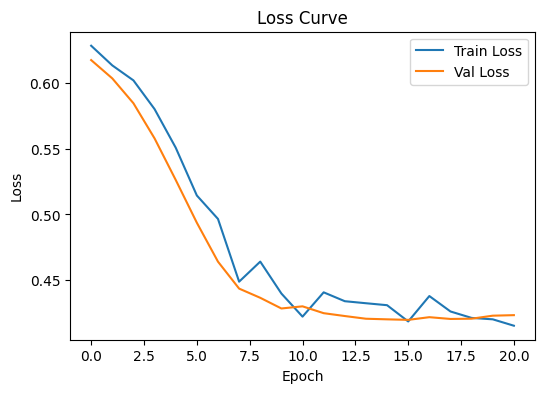

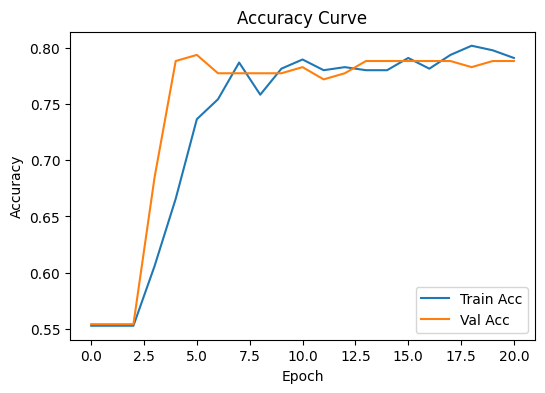

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss Curve'); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy Curve'); plt.legend(); plt.show()

Test Accuracy: 0.7880
ROC-AUC: 0.8650
F1-score: 0.8060
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77        82
           1       0.82      0.79      0.81       102

    accuracy                           0.79       184
   macro avg       0.79      0.79      0.79       184
weighted avg       0.79      0.79      0.79       184



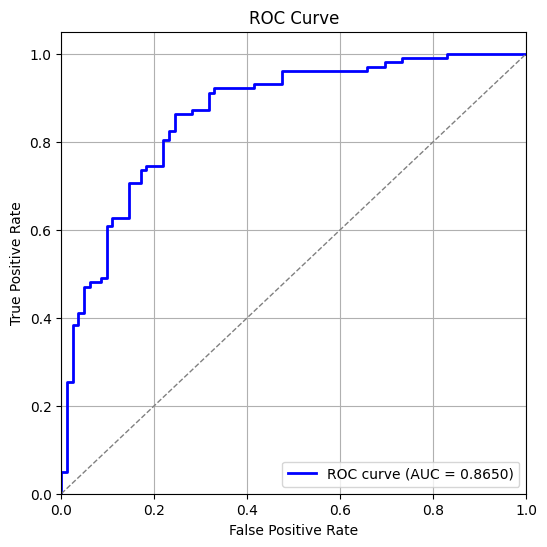

In [ ]:
model.eval()
with torch.no_grad():
    test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
    test_probs = torch.sigmoid(test_outputs).numpy().flatten()
    test_preds = (test_probs >= 0.5).astype(int)

acc = accuracy_score(y_test, test_preds)
roc = roc_auc_score(y_test, test_probs)
f1 = f1_score(y_test, test_preds)

print(f"Test Accuracy: {acc:.4f}")
print(f"ROC-AUC: {roc:.4f}")
print(f"F1-score: {f1:.4f}")
print("Classification Report:\n", classification_report(y_test, test_preds))


from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

F1-score: 0.8060


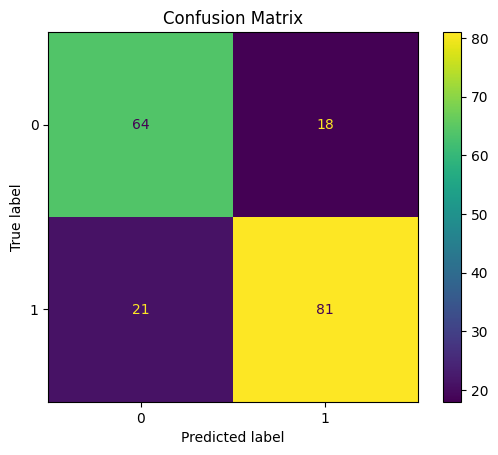

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)
plt.title("Confusion Matrix")
plt.show()